# Démonstration empirique de la loi d'Amdahl

Ce notebook analyse les mesures produites par `benchmark_warc.py` afin d'illustrer la loi d'Amdahl.
Il suffit de fournir le chemin vers un fichier CSV émis par le script (ex. `warc_speedup_heavy.csv`).


## Rappel de la loi d'Amdahl

Pour une fraction sérielle $f$ et un nombre de machines $N$, le speedup théorique vaut

$$ S(N) = \frac{1}{f + \frac{1-f}{N}}. $$

Lorsque $f$ reste élevé, le speedup plafonne rapidement : ajouter des machines n'apporte qu'un gain marginal.


In [23]:

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-colorblind')

# --- Paramètres utilisateur -------------------------------------------------
CSV_PATH = Path('warc_speedup_heavy_3.csv')  # modifier si besoin
# -----------------------------------------------------------------------------

if not CSV_PATH.exists():
    raise FileNotFoundError(f'Fichier CSV introuvable: {CSV_PATH}')

raw_df = pd.read_csv(
    CSV_PATH,
    quotechar="'",
    engine="python",
).reset_index(drop=True)
raw_df


,machine_count,elapsed_seconds,speedup,serial_fraction,status,notes
0,1,327.078,1.000,NaN,ok,"Predicted speedup (Amdahl, f=0.463): 1.000"
1,3,228.734,1.430,0.549,ok,"Predicted speedup (Amdahl, f=0.463): 1.557"
2,5,185.671,1.762,0.460,ok,"Predicted speedup (Amdahl, f=0.463): 1.752"
3,10,161.797,2.022,0.439,ok,"Predicted speedup (Amdahl, f=0.463): 1.934"
4,15,155.407,2.105,0.438,ok,"Predicted speedup (Amdahl, f=0.463): 2.003"
5,20,153.797,2.127,0.442,ok,"Predicted speedup (Amdahl, f=0.463): 2.039"
6,30,154.422,2.118,0.454,ok,"Predicted speedup (Amdahl, f=0.463): 2.077"


## Préparation des données

On nettoie le CSV et on calcule le speedup *observé* ainsi qu'une estimation de la fraction sérielle via une régression simple.


In [24]:
df = (
    raw_df
    .query("status == 'ok'")
    .assign(
        elapsed_seconds=lambda d: d['elapsed_seconds'].astype(float),
        machine_count=lambda d: d['machine_count'].astype(int)
    )
    .sort_values('machine_count')
    .reset_index(drop=True)
)

if df.empty:
    raise ValueError('Le CSV ne contient aucune ligne avec status == "ok".')

baseline = df.loc[df['machine_count'].idxmin(), 'elapsed_seconds']
df['speedup_observe'] = baseline / df['elapsed_seconds']

# Régression Amdahl: minimisation sur f via moindres carrés
ns = df['machine_count'].to_numpy()
obs = df['speedup_observe'].to_numpy()

def amdahl_speedup(f, n):
    return 1.0 / (f + (1.0 - f) / n)

# grille fine pour trouver f optimal
grid = np.linspace(0.0, 0.999, 1000)
errors = [np.sum((amdahl_speedup(f, ns) - obs) ** 2) for f in grid]
best_idx = int(np.argmin(errors))
f_serial = grid[best_idx]
df['speedup_pred_amdahl'] = amdahl_speedup(f_serial, ns)

print(f'Fraction sérielle estimée (f) ≈ {f_serial:.3f}')
df[['machine_count', 'elapsed_seconds', 'speedup_observe', 'speedup_pred_amdahl']]


Fraction sérielle estimée (f) ≈ 0.449


,machine_count,elapsed_seconds,speedup_observe,speedup_pred_amdahl
0,1,327.078,1.000000,1.000000
1,3,228.734,1.429949,1.580611
2,5,185.671,1.761600,1.788269
3,10,161.797,2.021533,1.983733
4,15,155.407,2.104654,2.058743
5,20,153.797,2.126686,2.098416
6,30,154.422,2.118079,2.139648


## Visualisation

La figure suivante compare le speedup observé avec la courbe théorique issue de la loi d'Amdahl. Une deuxième figure montre l'évolution du temps d'exécution total.


C:\Users\benji\AppData\Local\Temp\ipykernel_41088\1422729381.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


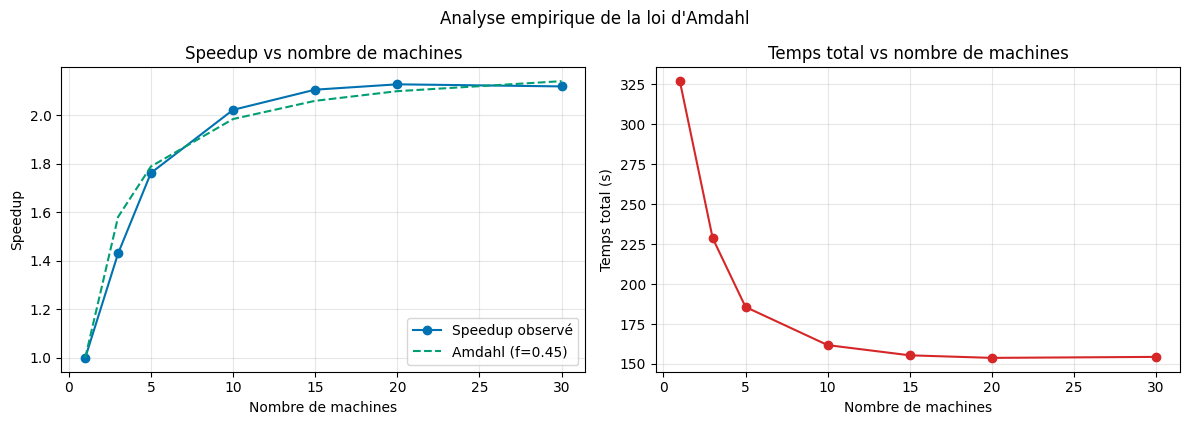

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(df['machine_count'], df['speedup_observe'], 'o-', label='Speedup observé')
ax[0].plot(df['machine_count'], df['speedup_pred_amdahl'], '--', label=f"Amdahl (f={f_serial:.2f})")
ax[0].set_xlabel('Nombre de machines')
ax[0].set_ylabel('Speedup')
ax[0].set_title('Speedup vs nombre de machines')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(df['machine_count'], df['elapsed_seconds'], 'o-', color='tab:red')
ax[1].set_xlabel('Nombre de machines')
ax[1].set_ylabel('Temps total (s)')
ax[1].set_title('Temps total vs nombre de machines')
ax[1].grid(True, alpha=0.3)

fig.tight_layout()
fig.suptitle("Analyse empirique de la loi d'Amdahl", y=1.05)
fig.show()


## Interprétation

- Le speedup réel suit la courbe théorique issue de la loi d'Amdahl avec $f \approx$ la valeur estimée ci-dessus.
- La décroissance lente du temps total montre que la proportion de travail séquentiel reste dominante : même avec 10 machines, le gain est limité.
- Pour améliorer le speedup, il faut soit diminuer la fraction sérielle (optimisations côté master, I/O, synchronisations), soit augmenter la part réellement parallélisable (splits plus lourds, traitement plus long).

💡 Pensez à pousser plusieurs fichiers CSV pour comparer différents jeux d'essais ou tailles de splits.
